In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.2],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = None))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.8333333333333334, Loss: 0.6759105258517795
Checkpoint 200, Accuracy: 0.8333333333333334, Loss: 0.6662459903293185
Checkpoint 300, Accuracy: 0.8333333333333334, Loss: 0.671555342497649
Checkpoint 400, Accuracy: 0.8333333333333334, Loss: 0.674697098908601
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.675280111807364


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.7065511 ]
 [0.21132876]
 [0.08212014]]
[1. 0. 0.] <-> [[0.91712433]
 [0.06252967]
 [0.02034601]]
[1. 0. 0.] <-> [[0.8874105 ]
 [0.08545021]
 [0.02713928]]
[0. 1. 0.] <-> [[0.02683035]
 [0.44240645]
 [0.53076315]]
[0. 0. 1.] <-> [[0.7872118 ]
 [0.16372094]
 [0.04906731]]
[0. 0. 1.] <-> [[0.91669726]
 [0.06285549]
 [0.02044723]]
[1. 0. 0.] <-> [[0.71097976]
 [0.21376565]
 [0.0752546 ]]
[1. 0. 0.] <-> [[0.826346  ]
 [0.13324444]
 [0.04040964]]
[0. 1. 0.] <-> [[0.01183529]
 [0.41220734]
 [0.5759574 ]]
[1. 0. 0.] <-> [[0.70654863]
 [0.13565135]
 [0.15780002]]
[1. 0. 0.] <-> [[0.8409495 ]
 [0.12178858]
 [0.03726197]]
[1. 0. 0.] <-> [[0.90076905]
 [0.07509557]
 [0.0241354 ]]
[0. 1. 0.] <-> [[0.7235077 ]
 [0.14607506]
 [0.1304172 ]]
[1. 0. 0.] <-> [[0.8755543 ]
 [0.09468626]
 [0.02975936]]
[1. 0. 0.] <-> [[0.89642096]
 [0.07845876]
 [0.02512026]]
[1. 0. 0.] <-> [[0.8422525 ]
 [0.12076609]
 [0.03698138]]
[1. 0. 0.] <-> [[0.84376705]
 [0.11957776]
 [0.0366552 ]]
[1. 0. 0.] <->

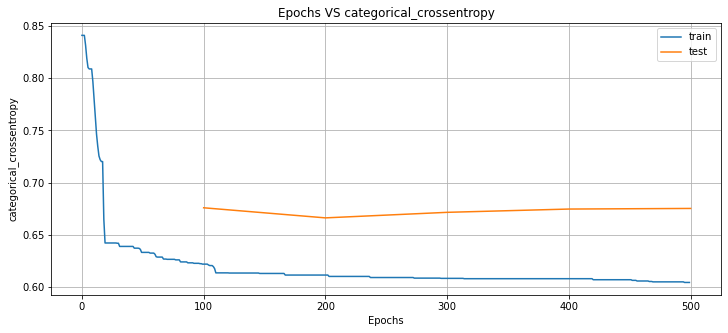

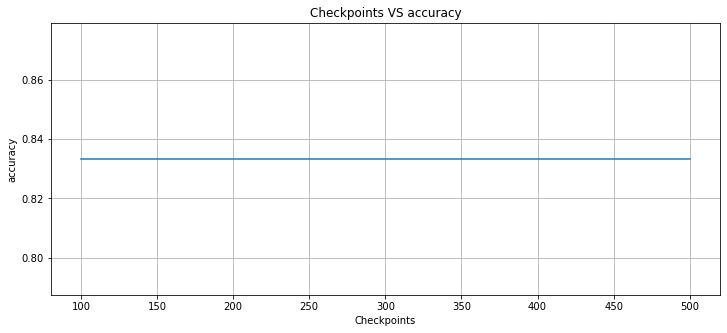

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8333333333333334, 'mean_square_error': 2.955238417132445, 'categorical_crossentropy': 0.6759105258517795, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 100} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.964099910972497, 'categorical_crossentropy': 0.6662459903293185, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 11}}, 'checkpoint': 200} 


{'accuracy': 0.8333333333333334, 'mean_square_error': 2.971582433239306, 'categorical_crossentropy': 0.671555342497649, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 23, 'tn_hit': 7, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 3, 'fp_hit': 4, 'tn_hit': 90, 'fn_hit': 

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[-1.5972584 ]
 [-1.8025104 ]
 [-0.07075604]
 [-2.0842962 ]
 [ 0.4332109 ]]
 bias: [3.]

Neuron 1: weights:
[[-0.79228723]
 [ 1.1845021 ]
 [ 1.5083286 ]
 [-0.97762513]
 [-2.3326292 ]]
 bias: [2.4054835]

Neuron 2: weights:
[[ 0.18982765]
 [ 0.7405991 ]
 [-1.3099562 ]
 [ 2.3490624 ]
 [-0.97340995]]
 bias: [-1.1162548]

Neuron 3: weights:
[[ 1.7388016 ]
 [ 0.23399606]
 [-1.7344829 ]
 [ 1.1175935 ]
 [-1.945194  ]]
 bias: [2.4748926]

$
Layer 2
Neuron 0: weights:
[[ 0.40005195]
 [ 3.        ]
 [-2.4532747 ]
 [ 2.4026606 ]]
 bias: [0.73479915]

Neuron 1: weights:
[[ 3.       ]
 [-0.8823975]
 [ 3.       ]
 [ 1.8294755]]
 bias: [-0.31990883]

Neuron 2: weights:
[[ 0.97466636]
 [-0.19905002]
 [ 1.8765903 ]
 [-0.7537066 ]]
 bias: [2.466943]

$

